## Import packages

In [1]:
%matplotlib inline
from __future__ import print_function

import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, GRU, Dropout, Reshape, Merge, Bidirectional
from keras.callbacks import Callback, ModelCheckpoint

from sklearn.manifold import TSNE

Using TensorFlow backend.


## Download data files

In [2]:
! wget -q -O emoji_joined.txt https://raw.githubusercontent.com/uclmr/emoji2vec/master/data/raw_training_data/emoji_joined.txt
! wget -q http://nlp.stanford.edu/data/glove.6B.zip
! unzip -q -o glove.6B.zip
! rm -f glove.6B.zip glove.6B.50d.txt glove.6B.100d.txt glove.6B.200d.txt

## Initialize global variables

In [3]:
GLOVE_FILE = 'glove.6B.300d.txt'
EMOJI_DESCRIPTIONS_FILE = 'emoji_joined.txt'
EMOJI_EMB_VIZ_FILE = 'emoji_emb_viz.csv'
MODEL_WEIGHTS_FILE = 'weights.h5'
EMOJI_EMBEDDINGS_FILE = 'emoji_embeddings.txt'

MAX_SEQUENCE_LENGTH = 15
MAX_NB_WORDS = 5000
MAX_NB_EMOJIS = 2000
EMBEDDING_DIM = 300

RNG_SEED_1 = 1446557
RNG_SEED_2 = 1337603
VALIDATION_SPLIT = 0.1

## Load emojis

In [4]:
emoji_descriptions = pd.read_csv(EMOJI_DESCRIPTIONS_FILE, 
                                 sep='\t', 
                                 engine='python', 
                                 encoding='utf_8',
                                 names=['description', 'emoji'])

print('Emoji descriptions: %d' % len(emoji_descriptions))

Emoji descriptions: 6088


In [5]:
emoji_descriptions.head(5)

,description,emoji
0,ballot box with check,☑️
1,full moon with face,🌝
2,cheese,🌝
3,moon,🌝
4,smiling moon,🌝


In [6]:
neg_emoji_descriptions = pd.DataFrame({'emoji': emoji_descriptions['emoji'].values, 
                                       'description': emoji_descriptions.sample(frac=1, 
                                                                                random_state=RNG_SEED_1)['description'].values})

In [7]:
neg_emoji_descriptions.head(5)

,description,emoji
0,flag for jordan,☑️
1,middle school,🌝
2,menorah,🌝
3,old man,🌝
4,jazz,🌝


In [8]:
emoji_descriptions['label'] = 1
neg_emoji_descriptions['label'] = 0
emoji_data = pd.concat([emoji_descriptions, neg_emoji_descriptions]).sample(frac=1, random_state=RNG_SEED_2)

In [9]:
emoji_data.head(10)

,description,emoji,label
4078,arab,▫️,0
468,black man with turban,🈵,0
2407,sad cat,😿,1
1530,flag for brazil,🇧🇷,1
4797,accessible bathroom,💴,0
5890,white left pointing backhand index,🍳,0
5401,blond,👱,1
2520,face with open mouth and cold sweat,😰,1
747,slow,🐢,1
5770,mobile phone,📱,1


In [10]:
emoji_series = emoji_descriptions.groupby('emoji')['description'].apply(lambda x: ', '.join(x))
emojis_combined_desc = pd.DataFrame({'emoji': emoji_series.index, 'description': emoji_series.values})

print('Emojis: %d' % len(emojis_combined_desc))

Emojis: 1661


In [11]:
emojis_combined_desc[emojis_combined_desc['description'].str.contains('new york')]

,description,emoji
606,"slice of pizza, pie, italy, pepperoni pizza, s...",🍕
1362,"statue of liberty, new york",🗽
1506,"taxicab, city, new york taxi, car, service, au...",🚕


## Build emoji index

In [12]:
emojis = emojis_combined_desc['emoji'].values
emoji_index = {}
emoji_reverse_index = {}
i = 0
for e in emojis:
    i += 1
    emoji_index[e] = i
    emoji_reverse_index[i] = e

print("Emojis in index: %d" % len(emoji_index))

Emojis in index: 1661


## Build word index

In [13]:
descriptions = emoji_data['description'].values
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(descriptions.tolist())
desc_word_sequences = tokenizer.texts_to_sequences(descriptions.tolist())
word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))

Words in index: 3364


## Load GloVe word embeddings

In [14]:
embeddings_index = {}
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

Word embeddings: 400000


## Prepare word embedding matrix

In [15]:
nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        word_embedding_matrix[i] = embedding_vector
        
print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))

Null word embeddings: 72


## Prepare training data

In [16]:
e_data = np.array([ emoji_index[e] for e in emoji_data['emoji'].values ])
d_data = pad_sequences(desc_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array([ [0, 1] if l == 0 else [1, 0] for l in emoji_data['label'].values ])
nb_emojis = min(MAX_NB_EMOJIS, len(emoji_index))

print('Shape of emoji data tensor:', e_data.shape)
print('Shape of description data tensor:', d_data.shape)
print('Shape of label tensor:', labels.shape)
print('Number of emojis:', nb_emojis)

Shape of emoji data tensor: (12176,)
Shape of description data tensor: (12176, 15)
Shape of label tensor: (12176, 2)
Number of emojis: 1661


## Define model

In [17]:
P = Sequential()
P.add(Embedding(nb_emojis + 1, EMBEDDING_DIM, input_length=1))
P.add(Reshape((EMBEDDING_DIM,)))
Q = Sequential()
Q.add(Embedding(nb_words + 1, 
                EMBEDDING_DIM, 
                weights=[word_embedding_matrix], 
                input_length=MAX_SEQUENCE_LENGTH, 
                trainable=False))
Q.add(Bidirectional(GRU(EMBEDDING_DIM, dropout_W=0.5, dropout_U=0.5), merge_mode='sum'))
model = Sequential()
model.add(Merge([P, Q], mode='concat'))
model.add(Dropout(0.5))
model.add(Dense(EMBEDDING_DIM*2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

## Train model

In [18]:
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_categorical_accuracy', save_best_only=True)]
history = model.fit([e_data, d_data], 
                    labels, 
                    nb_epoch=80, 
                    validation_split=VALIDATION_SPLIT, 
                    verbose=2, 
                    callbacks=callbacks)

Train on 10958 samples, validate on 1218 samples
Epoch 1/80
17s - loss: 0.7291 - categorical_accuracy: 0.4809 - val_loss: 0.7004 - val_categorical_accuracy: 0.4729
Epoch 2/80
16s - loss: 0.7038 - categorical_accuracy: 0.4998 - val_loss: 0.6958 - val_categorical_accuracy: 0.4770
Epoch 3/80
16s - loss: 0.6984 - categorical_accuracy: 0.4967 - val_loss: 0.6958 - val_categorical_accuracy: 0.4655
Epoch 4/80
16s - loss: 0.6966 - categorical_accuracy: 0.5109 - val_loss: 0.6938 - val_categorical_accuracy: 0.5099
Epoch 5/80
16s - loss: 0.6947 - categorical_accuracy: 0.5128 - val_loss: 0.6959 - val_categorical_accuracy: 0.4975
Epoch 6/80
16s - loss: 0.6919 - categorical_accuracy: 0.5220 - val_loss: 0.6932 - val_categorical_accuracy: 0.5140
Epoch 7/80
16s - loss: 0.6775 - categorical_accuracy: 0.5594 - val_loss: 0.6811 - val_categorical_accuracy: 0.5517
Epoch 8/80
16s - loss: 0.6417 - categorical_accuracy: 0.6139 - val_loss: 0.6665 - val_categorical_accuracy: 0.5936
Epoch 9/80
16s - loss: 0.5842 -

## Plot accuracy

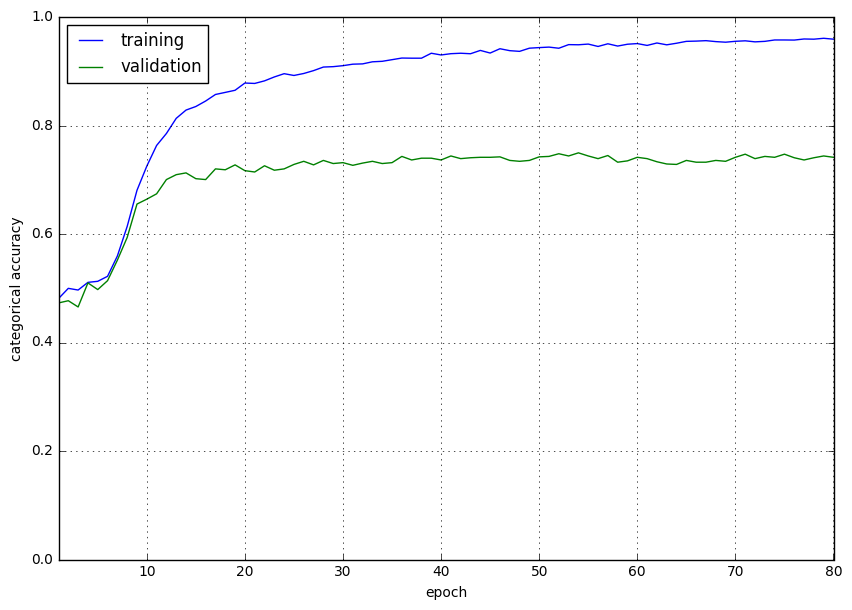

In [19]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['categorical_accuracy'],
                    'validation': history.history['val_categorical_accuracy']})
ax = acc.ix[:,:].plot(x='epoch', figsize={7,10}, grid=True)
ax.set_ylabel("categorical accuracy")
ax.set_ylim([0.0,1.0]);

## Plot loss

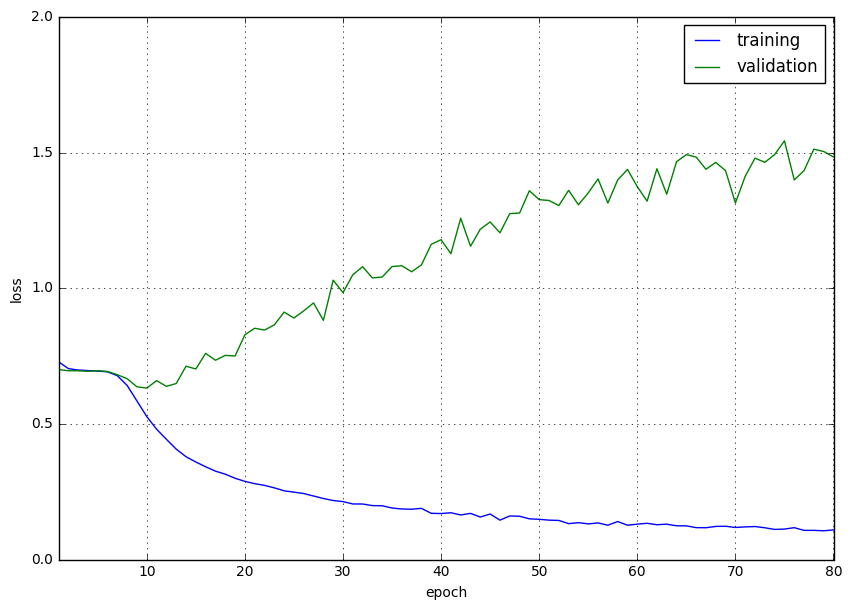

In [20]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': history.history['loss'],
                     'validation': history.history['val_loss']})
ax = loss.ix[:,:].plot(x='epoch', figsize={7,10}, grid=True)
ax.set_ylabel("loss")
ax.set_ylim([0.0,2.0]);

## Extract emoji embeddings from the best model checkpoint and save them to a file

In [21]:
model.load_weights(MODEL_WEIGHTS_FILE)
weights = P.layers[0].get_weights()[0]
embeddings = pd.DataFrame(weights[1:])
embeddings = pd.concat([emojis_combined_desc['emoji'], embeddings], axis=1)

embeddings.to_csv(EMOJI_EMBEDDINGS_FILE, sep=' ', header=False, index=False)

## Plot t-SNE visualization and save it to a file

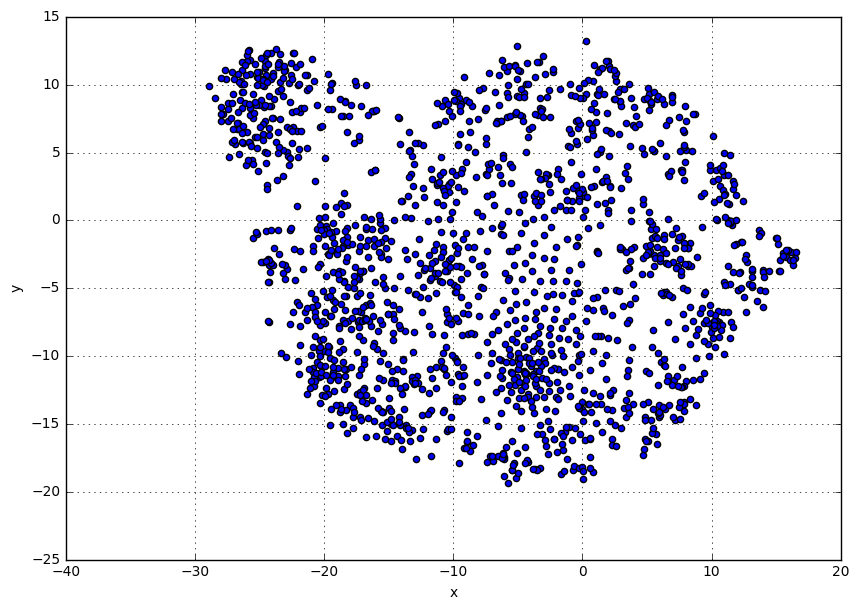

In [22]:
tsne2 = TSNE(n_components=2, perplexity=30, init='pca', n_iter=5000)
fit = tsne2.fit_transform(weights)
visualization = pd.DataFrame(fit[1:], columns=['x', 'y'])
visualization['emoji'] = emojis_combined_desc['emoji'].values
visualization.plot('x', 'y', kind='scatter', figsize={7,10}, grid=True);

visualization.to_csv(EMOJI_EMB_VIZ_FILE)